In [2]:
import itertools
import numpy as np
import numpy.random as npr
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import colors
from matplotlib import gridspec
import matplotlib

import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D  

import scipy.io
from scipy.io import loadmat
from scipy.io import savemat
from scipy import stats
from scipy.special import softmax
from sklearn.metrics import log_loss
import pickle
import copy

%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.family':'Arial'})

## Read Data

In [21]:
subjectNames = ['sam','tabitha','chloe','blanche','b01','b02','b03','b04','b05','b06','b07','b08','b09','b10']

numSubjects = len(subjectNames)

stateNames = ['Persist','Preferred','Random','Avoid']
historyNames = ['(0,0)','(1,0)','(0,1)','(1,1)']

speciesList = np.array([0,0,0,0,1,1,1,1,1,2,2,2,2,2])

speciesColor = ['#fb8072','#8dd3c7','#74add1']
speciesDColor = ['#6a0e03','#1d4c44','#183649']
speciesNames = ['monkey','human','human2']
speciesNameLeg = ['Monkeys','Human DS1', 'Human DS2']

distrColors = np.array([[228,26,28],
[55,126,184],
[77,175,74],
[152,78,163],
[255,127,0],
[166,86,40]])/255

def getPM(N):
    if N == 1:
        return 1
    elif N > 1:
        x = np.zeros([N])
        x[0] = 1
        for i in np.arange(1,N):
            x[i] = -1 * x[i-1]
        return x

######################################
    
analysis = []
data = []
data0 = []


for i in range(numSubjects):
    with open('analysis/tmp/'+subjectNames[i]+'.pickle', 'rb') as f:
#     with open('analysis'+subjectNames[i]+'.pickle', 'rb') as f:
        [A] = pickle.load(f)
    analysis.append(A)
    with open('data/tmp/'+subjectNames[i]+'.pickle', 'rb') as f:
#     with open('data/'+subjectNames[i]+'.pickle', 'rb') as f:
        [D] = pickle.load(f)
    data.append(D)
    data0.append(D)


categoryNames = ['Perseveration',
                 'Random search',
                 'Non-rule \n exploration',
                 'Rule favored, \n exploration',
                 'Rule preferred',
                 'Rule exploitation']

## 

## Evolution of learning according to trial categories

In [9]:
# Collect data
bw = 0.05
bins = np.arange(0,1+bw,bw)
numBins = bins.shape[0]-1

whenCategoryNormalized = np.zeros([numSubjects,6,numBins])
whenRewardNormalized = np.zeros([numSubjects,numBins])
for i in range(numSubjects):
    whenCategoryNormalized[i] = analysis[i]['categoryAnalysis']['probabilityCategory']
    whenRewardNormalized[i] = analysis[i]['categoryAnalysis']['probabilityReward']


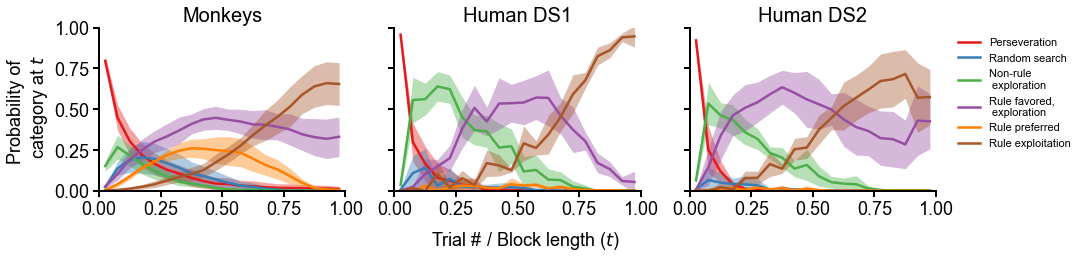

In [23]:
fig, ax = plt.subplots(sharey=True,sharex=True,ncols=3,nrows=1,figsize=(15,3))

fig.text(0.52, -0.13, 'Trial # / Block length ($t$)', ha='center', size=18)

binCenters = bins[:-1] + bw/2

for spInd in range(3): # Species
    idx = np.where(np.array(speciesList) == spInd)[0]

    for i in range(6): # Categories
        Y = whenCategoryNormalized[idx,i,:]
        meanY = np.mean(Y,axis=0)
        stdY = np.std(Y,axis=0)
        stderrY = stdY / np.sqrt(len(idx))

        loY = meanY - stdY
        hiY = meanY + stdY

        # Plot
        ax[spInd].plot(binCenters,meanY,color=distrColors[i],label=categoryNames[i],linewidth=2.5)
        ax[spInd].fill_between(binCenters,loY,hiY,alpha=0.4,color=distrColors[i],linewidth=0)
        ax[spInd].set_title(speciesNameLeg[spInd],fontsize=20)
        if spInd == 0:
            ax[spInd].set_ylabel('Probability of \n category at $t$',fontsize=18)
        if spInd == 2:
            ax[spInd].legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,fontsize=11)

    # Prettify
    ax[spInd].set_ylim([0,1])
    ax[spInd].set_xlim([0,1])
    ax[spInd].set_yticks([0,0.25,0.5,0.75,1])
    ax[spInd].set_xticks([0,0.25,0.5,0.75,1])
    ax[spInd].tick_params(axis='x',labelsize= 18,direction='out',width=2,length=6)
    ax[spInd].tick_params(axis='y',labelsize= 18,direction='out',width=2,length=6)
    ax[spInd].spines['right'].set_visible(False)
    ax[spInd].spines['top'].set_visible(False)

    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[spInd].spines[axis].set_linewidth(2)


#plt.savefig('figures/fig5/catNormTr.eps', format='eps')

### Evolution of reward probability

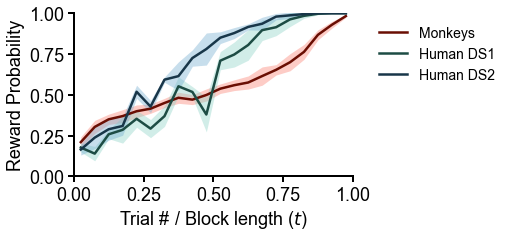

In [24]:
fig, ax = plt.subplots(sharey=True,sharex=True,ncols=1,nrows=1,figsize=(5,3))

# fig.text(0.52, -0.13, 'Trial # / Block length ($t$)', ha='center', size=18)

binCenters = bins[:-1] + bw/2

for spInd in range(3): # Species
    idx = np.where(np.array(speciesList) == spInd)[0]
    
    Y = whenRewardNormalized[idx,:]
    meanY = np.mean(Y,axis=0)
    stdY = np.std(Y,axis=0)
    stderrY = stdY / np.sqrt(len(idx))

    loY = meanY - stdY
    hiY = meanY + stdY

    # Plot
    ax.plot(binCenters,meanY,color=speciesDColor[spInd],label=speciesNameLeg[spInd],linewidth=2.5)
    ax.fill_between(binCenters,loY,hiY,alpha=0.4,color=speciesColor[spInd],linewidth=0)
    
# Prettify
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,fontsize=14)
ax.set_ylabel('Reward Probability',fontsize=18)
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_ylim([0,1])

ax.set_xlabel('Trial # / Block length ($t$)',fontsize=18)
ax.set_xlim([0,1])
ax.set_xticks([0,0.25,0.5,0.75,1])
ax.tick_params(axis='x',labelsize= 18,direction='out',width=2,length=6)
ax.tick_params(axis='y',labelsize= 18,direction='out',width=2,length=6)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# change all spines
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# plt.savefig('figures/fig5/rewProbNormTr.eps', format='eps')

## Trial category stats / metrics

In [16]:
# Collect data
Lc = np.zeros([numSubjects,6])
LcCP = np.zeros([4,3,6])
VarLc = np.zeros([numSubjects,6])
propLc = np.zeros([numSubjects,6])
covvarLc = np.zeros([numSubjects,6])
rr = np.zeros([numSubjects,6])


for i in range(numSubjects):
    Lc[i] = analysis[i]['categoryAnalysis']['meanLCategory']
    VarLc[i] = analysis[i]['categoryAnalysis']['varLCategory']
    propLc[i] = analysis[i]['categoryAnalysis']['propLCategory']
    covvarLc[i] = analysis[i]['categoryAnalysis']['covvarLCategory']
    rr[i] = np.nanmean(analysis[i]['categoryAnalysis']['rewRateCat'],axis=1)

/var/folders/d0/w_19qmbx12q36d9zs46hfymm0000gn/T/ipykernel_53806/3440583301.py:15: RuntimeWarning: Mean of empty slice
  rr[i] = np.nanmean(analysis[i]['categoryAnalysis']['rewRateCat'],axis=1)


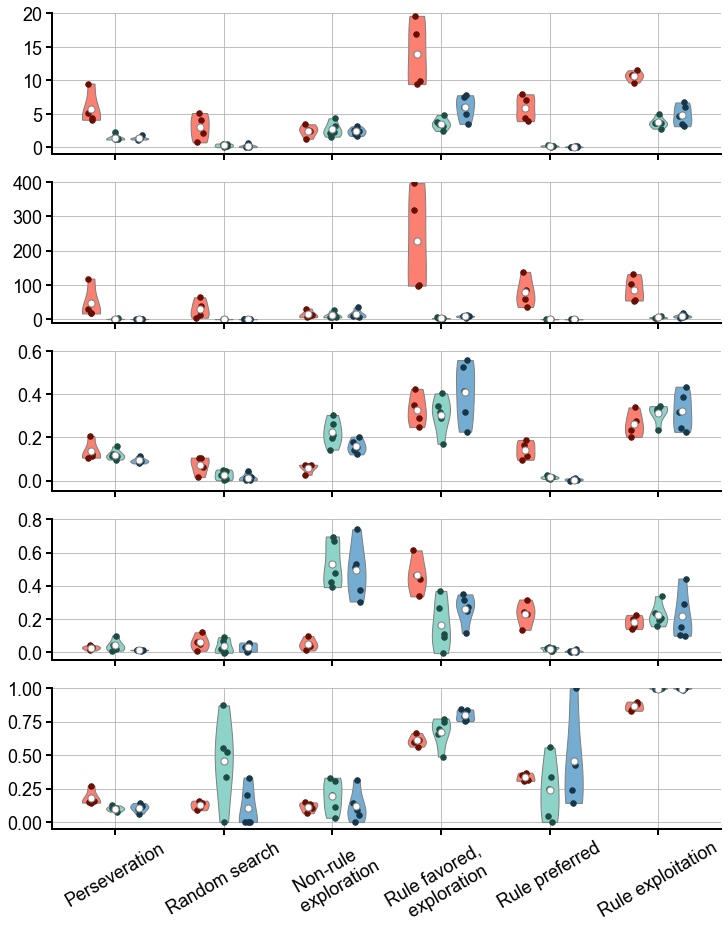

In [27]:
# Plot
fig, ax = plt.subplots(ncols=1,nrows=5,sharex=True,figsize=(6*2,3*5))

vpWidth = 0.4
mxs = [20, 400, 0.6, 0.8, 1.0]
mns = [-1, -10, -0.05, -0.05, -0.05]
YTs = [[0,5,10,15,20],
       [0,100,200,300,400],
       [0,0.2,0.4,0.6],
       [0,0.2,0.4,0.6,0.8],
       [0,0.25,0.5,0.75,1.0]]
DATs = [Lc, VarLc, propLc, covvarLc, rr]
for d in range(5): # metric
    dat = DATs[d]
    mx = mxs[d]
    mn = mns[d]
    YT = YTs[d]

    XT = []
    for i in range(6): # category

        for spInd in range(3): # Species
            idx = np.where(np.array(speciesList) == spInd)[0]
            dat1 = dat[idx,i]
            dat1 = np.delete(dat1,np.where(np.isnan(dat1))[0], axis=0)
            x1 = -vpWidth/1.5 + spInd*(vpWidth/1.5)#*1.5

            # Violins
            vp1 = ax[d].violinplot(dat1,[x1+i*1.2],showextrema=False,widths=0.5*vpWidth)
            for pc in vp1['bodies']:
                pc.set_facecolor(speciesColor[spInd])
                pc.set_edgecolor('gray')
                pc.set_alpha(1)

            # Points
            x = npr.rand(dat1.size) * (vpWidth) * (0.1)
            pm = getPM(x.shape[0])
            x = np.multiply(x,pm) + x1 +i*1.2
            ax[d].scatter(x,dat1,s=30,color=speciesDColor[spInd])
            ax[d].scatter(x1+i*1.2,np.mean(dat1),color='white',s=50,edgecolors='gray')


        XT.append(i*1.2)

    # Prettify
    ax[d].set_ylim([mn,mx])
    ax[d].set_xlim([-0.7,6.7])
    ax[d].set_xticks(XT)
    ax[d].set_xticklabels(categoryNames,fontsize=1, rotation=30)
    ax[d].set_yticks(YT)
    ax[d].tick_params(axis='x',labelsize= 18,direction='out',width=2,length=6)
    ax[d].tick_params(axis='y',labelsize= 18,direction='out',width=2,length=6)
    ax[d].spines['right'].set_visible(False)
    ax[d].spines['top'].set_visible(False)

    # change all spines
    for axis in ['top','bottom','left','right']:
        ax[d].spines[axis].set_linewidth(2)
    ax[d].grid(which='major', axis='both')
    ax[d].set_axisbelow(True)
    
# plt.savefig('figures/fig5/catStats.eps', format='eps')

## Statistical testing

In [29]:
# Helper bootstrap
def calcBootstrp(data1, data2):
    data1 = np.array(data1)
    data2 = np.array(data2)
    s = stats.ttest_ind(data1, data2, equal_var=False)
    t = s.statistic

    data1_hat = data1-np.mean(data1) + np.mean(np.concatenate([data1, data2]))
    data2_hat = data2-np.mean(data2) + np.mean(np.concatenate([data1, data2]))
    t_stars = []
    for i in range(10000):
        data1_samp = np.random.choice(data1_hat,size=data1.shape[0])
        data2_samp = np.random.choice(data2_hat,size=data2.shape[0])
        s = stats.ttest_ind(data1_samp, data2_samp, equal_var=False)
        t_stars.append(s.statistic)

    return t, t_stars

In [33]:
# Compare mean # trials in each category across species
for i in range(np.shape(Lc)[1]):
    hmn = []
    hmn2 = []
    mmn = []
    for j in range(4,9):
        hmn.append(Lc[j,i])
    for j in range(9,np.shape(Lc)[0]):
        hmn2.append(Lc[j,i])
    for j in range(4):
        mmn.append(Lc[j,i])

    t, t_stars = calcBootstrp(hmn,mmn)
    t2, t_stars2 = calcBootstrp(hmn2,mmn)
    print(categoryNames[i] +' \t: ' + str(np.mean(t_stars<=t))+' , ' + str(np.mean(t_stars2<=t2)))

Perseveration 	: 0.0045 , 0.0038
Random search 	: 0.0641 , 0.0628
Non-rule 
 exploration 	: 0.6559 , 0.4351
Rule favored, 
 exploration 	: 0.0582 , 0.058
Rule preferred 	: 0.0608 , 0.0643
Rule exploitation 	: 0.0006 , 0.0026
